In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from utils import get_range, get_metrics
from models import NaiveSharpe

# Filter performance warnings
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

### Generate portfolio from naive Sharpe optimiser

In [10]:
# Load in the full price dataframes
price_df = pd.read_pickle("spx_df_2025-04-08")
index_price_df = pd.read_pickle("spx_index_df_2025-04-08")

# Past date range
past_start_date = "2023-04-08"
past_end_date = "2024-04-07"

# Get prices for selected date ranges
past_price_df = get_range(past_start_date, past_end_date, price_df)
past_spx_df = get_range(past_start_date, past_end_date, index_price_df)

# Join stocks and index dataframes
past_price_df = pd.concat([past_price_df, past_spx_df], axis=1)

# Get metrics for past price history
daily_returns, daily_log_returns, \
annualised_returns, annualised_log_returns, \
top_n_stocks, covariance_matrix = get_metrics(past_price_df, n=50, show=False)

naive_model = NaiveSharpe(annualised_log_returns, top_n_stocks, covariance_matrix)
naive_model.optimise(show_results=False, plot_weights=False)
naive_model.hedge()
trades = naive_model.get_transactions(past_end_date, capital=1000000, prices=past_price_df.iloc[-1])

### Backtest class

In [11]:
class StockBacktest:
    def __init__(self, start_date, end_date, initial_cash=1000000):
        """
        Initialize the stock backtest system
        
        Parameters:
        - start_date: Starting date for the simulation
        - end_date: Ending date for the simulation
        - initial_cash: Initial cash position
        """
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.dates = pd.date_range(start=self.start_date, end=self.end_date)
        
        # Initialize positions and tracking
        self.initial_cash = initial_cash
        self.cash_position = pd.Series(initial_cash, index=self.dates, dtype=float)
        self.stock_positions = {}  # {ticker: quantity}
        self.positions_history = pd.DataFrame(index=self.dates, dtype=float)
        self.positions_value = pd.Series(0, index=self.dates, dtype=float)
        self.transactions = []
        
        # Results tracking
        self.daily_pnl = pd.Series(0, index=self.dates, dtype=float)
        self.cumulative_pnl = pd.Series(0, index=self.dates, dtype=float)
        
        # Market data
        self.prices = {}  # {ticker: Series of prices}
        self.market_data = None
        
        # Shorting tracking
        self.shorting_cost = 0.0005  # 5 basis points per day (annualized 1.825%)
        self.short_positions = {}  # {ticker: {'quantity': qty, 'borrowing_cost': cost}}
        self.short_costs_history = pd.Series(0, index=self.dates, dtype=float)

        # Dictionary of trades
        self.trades = {}
    
    def load_market_data(self, price_data):
        """
        Load market price data
        
        Parameters:
        - price_data: DataFrame with dates as index and tickers as columns
        """
        self.market_data = price_data.reindex(self.dates, method='ffill')
        
        # Initialize position history columns
        for ticker in self.market_data.columns:
            self.positions_history[ticker] = 0
    
    def execute_trade(self, date, ticker, quantity, price=None):
        """
        Execute a stock trade
        
        Parameters:
        - date: Trade date
        - ticker: Stock ticker symbol
        - quantity: Number of shares (positive for buy, negative for sell)
        - price: Price per share (if None, will use market price)
        """
        date = pd.to_datetime(date)
        
        # Ensure market data exists for this ticker
        if self.market_data is None or ticker not in self.market_data.columns:
            raise ValueError(f"No market data available for {ticker}")
        
        # Use market price if not specified
        if price is None:
            price = self.market_data.loc[date, ticker]
        
        # Calculate trade value (negative for buys, positive for sells)
        trade_value = -quantity * price
        
        # Check if going short or covering short
        if ticker in self.stock_positions:
            current_position = self.stock_positions[ticker]
            if current_position < 0 and quantity > 0:  # Covering short
                cover_quantity = min(quantity, abs(current_position))
                self._handle_short_covering(date, ticker, cover_quantity, price)
        
        # Update positions
        if ticker not in self.stock_positions:
            self.stock_positions[ticker] = 0
            
        self.stock_positions[ticker] += quantity
        
        # Handle shorting
        if self.stock_positions[ticker] < 0:
            self._handle_shorting(date, ticker)
        
        # Update cash position
        idx = self.cash_position.index.get_indexer([date], method='ffill')[0]
        self.cash_position.iloc[idx:] += trade_value
        
        # Record transaction
        self.transactions.append({
            'date': date,
            'ticker': ticker,
            'quantity': quantity,
            'price': price,
            'value': -trade_value,
            'type': 'buy' if quantity > 0 else 'sell'
        })
        
        # Update position history
        self._update_positions(date)
    
    def _handle_shorting(self, date, ticker):
        """
        Handle shorting logistics when a short position is established or increased
        
        Parameters:
        - date: Current date
        - ticker: Stock ticker symbol
        """
        short_qty = abs(self.stock_positions[ticker])
        
        if ticker not in self.short_positions:
            self.short_positions[ticker] = {
                'quantity': short_qty,
                'borrowing_cost': self.shorting_cost
            }
        else:
            self.short_positions[ticker]['quantity'] = short_qty
    
    def _handle_short_covering(self, date, ticker, cover_quantity, price):
        """
        Handle the covering of a short position
        
        Parameters:
        - date: Current date
        - ticker: Stock ticker symbol
        - cover_quantity: Number of shares to cover
        - price: Current price
        """
        if ticker in self.short_positions:
            self.short_positions[ticker]['quantity'] -= cover_quantity
            
            if self.short_positions[ticker]['quantity'] <= 0:
                del self.short_positions[ticker]
    
    def _update_positions(self, date):
        """
        Update the positions history dataframe
        
        Parameters:
        - date: Current date
        """
        idx = self.positions_history.index.get_indexer([date], method='ffill')[0]
        
        # Initialize all positions to 0 first
        for ticker in self.positions_history.columns:
            self.positions_history.iloc[idx:, self.positions_history.columns.get_loc(ticker)] = 0
        
        # Update with current positions
        for ticker, quantity in self.stock_positions.items():
            if ticker in self.positions_history.columns:
                self.positions_history.iloc[idx:, self.positions_history.columns.get_loc(ticker)] = quantity
    
    def _calculate_position_value(self, date):
        """
        Calculate the total value of stock positions for a given date
        
        Parameters:
        - date: Date for calculation
        
        Returns:
        - Total value of all positions
        """
        total_value = 0
        
        for ticker, quantity in self.stock_positions.items():
            if ticker in self.market_data.columns:
                price = self.market_data.loc[date, ticker]
                total_value += quantity * price
        
        return total_value
    
    def _calculate_short_costs(self, date):
        """
        Calculate the daily borrowing costs for short positions
        
        Parameters:
        - date: Current date
        
        Returns:
        - Total borrowing cost for the day
        """
        total_cost = 0
        
        for ticker, details in list(self.short_positions.items()):
            quantity = details['quantity']
            borrow_rate = details['borrowing_cost']
            price = self.market_data.loc[date, ticker]
            
            # Daily cost (annual rate / 365)
            daily_cost = quantity * price * borrow_rate / 365
            total_cost += daily_cost
        
        return total_cost
    
    def _process_short_costs(self, date):
        """
        Process borrowing costs for short positions
        
        Parameters:
        - date: Current date
        """
        daily_cost = self._calculate_short_costs(date)
        
        if daily_cost > 0:
            idx = self.cash_position.index.get_indexer([date], method='ffill')[0]
            self.cash_position.iloc[idx:] -= daily_cost
            self.short_costs_history.iloc[idx] = daily_cost
            
            # Record transaction
            self.transactions.append({
                'date': date,
                'ticker': 'BORROWING',
                'quantity': 0,
                'price': 0,
                'value': -daily_cost,
                'type': 'short_cost'
            })
    
    def _process_dividends(self, date, dividend_data):
        """
        Process dividend payments for all stocks on the given date
        
        Parameters:
        - date: Payment date to check for dividends
        - dividend_data: Dictionary of {ticker: dividend_amount} for this date
        """
        total_dividend = 0
        
        for ticker, dividend in dividend_data.items():
            if ticker in self.stock_positions:
                quantity = self.stock_positions[ticker]
                if quantity > 0:  # Only long positions receive dividends
                    dividend_payment = quantity * dividend
                    total_dividend += dividend_payment
                    
                    # Record transaction
                    self.transactions.append({
                        'date': date,
                        'ticker': ticker,
                        'quantity': 0,
                        'price': 0,
                        'value': dividend_payment,
                        'type': 'dividend'
                    })
                elif quantity < 0:  # Short positions pay dividends
                    dividend_payment = -quantity * dividend
                    total_dividend -= dividend_payment
                    
                    # Record transaction
                    self.transactions.append({
                        'date': date,
                        'ticker': ticker,
                        'quantity': 0,
                        'price': 0,
                        'value': -dividend_payment,
                        'type': 'short_dividend'
                    })
        
        if total_dividend != 0:
            # Update cash position
            idx = self.cash_position.index.get_indexer([date], method='ffill')[0]
            self.cash_position.iloc[idx:] += total_dividend
    
    def run_backtest(self, dividend_data=None):
        """
        Run the full backtest simulation
        
        Parameters:
        - dividend_data: Optional dict of {date: {ticker: amount}} for dividend processing
        """
        if dividend_data is None:
            dividend_data = {}
            
        for date in self.dates:
            # Execute trades for the day
            date_string = date.strftime("%Y-%m-%d")
            if date_string in self.trades.keys():
                for trade in self.trades[date_string]:
                    date_string = trade.date
                    ticker = trade.id
                    qty = trade.qty
                    self.execute_trade(date=date_string, ticker=ticker, quantity=qty)

            # Process dividends if any
            if date in dividend_data:
                self._process_dividends(date, dividend_data[date])
            
            # Process short position costs
            self._process_short_costs(date)
            
            # Calculate position values
            position_value = self._calculate_position_value(date)
            idx = self.positions_value.index.get_indexer([date])[0]
            self.positions_value.iloc[idx] = position_value
            
            # Calculate daily P&L
            if idx > 0:
                previous_cash = self.cash_position.iloc[idx-1]
                previous_positions = self.positions_value.iloc[idx-1]
                current_cash = self.cash_position.iloc[idx]
                current_positions = self.positions_value.iloc[idx]
                
                daily_pnl = (current_cash + current_positions) - (previous_cash + previous_positions)
                self.daily_pnl.iloc[idx] = daily_pnl
                
                self.cumulative_pnl.iloc[idx] = self.cumulative_pnl.iloc[idx-1] + daily_pnl
            else:
                self.cumulative_pnl.iloc[idx] = 0
    
    def generate_summary(self):
        """
        Generate summary statistics of the backtest
        
        Returns:
        - Dictionary with summary statistics
        """
        total_return = self.cumulative_pnl.iloc[-1]
        percent_return = total_return / self.initial_cash * 100
        
        if (self.end_date - self.start_date).days > 0:
            annual_return = (
                (1 + total_return / self.initial_cash) ** 
                (365 / (self.end_date - self.start_date).days) - 
                1
            ) * 100
        else:
            annual_return = 0
        
        volatility = self.daily_pnl.std() * np.sqrt(252) if len(self.daily_pnl) > 1 else 0
        sharpe_ratio = annual_return / (volatility / self.initial_cash * 100) if volatility != 0 else 0
        
        drawdown = (self.cumulative_pnl.cummax() - self.cumulative_pnl)
        max_drawdown = drawdown.max() / self.initial_cash * 100 if len(drawdown) > 0 else 0
        
        # Calculate long and short exposure
        final_long_exposure = sum(
            quantity * self.market_data.iloc[-1][ticker]
            for ticker, quantity in self.stock_positions.items()
            if quantity > 0
        )
        
        final_short_exposure = sum(
            quantity * self.market_data.iloc[-1][ticker]
            for ticker, quantity in self.stock_positions.items()
            if quantity < 0
        )
        
        # Calculate total borrowing costs
        total_borrowing_costs = self.short_costs_history.sum()
        
        return {
            'start_date': self.start_date,
            'end_date': self.end_date,
            'total_return': total_return,
            'percent_return': percent_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'final_cash_position': self.cash_position.iloc[-1],
            'final_stock_value': self.positions_value.iloc[-1],
            'final_long_exposure': final_long_exposure,
            'final_short_exposure': final_short_exposure,
            'total_borrowing_costs': total_borrowing_costs,
            'total_value': self.cash_position.iloc[-1] + self.positions_value.iloc[-1]
        }
    
    def plot_results(self):
        """
        Plot the results of the backtest
        """
        fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)
        
        # Plot stock positions (value)
        axes[0].plot(self.positions_value.index, self.positions_value, 'b-', linewidth=2)
        axes[0].set_title('Stock Position Value', fontsize=16)
        axes[0].set_ylabel('Value ($)', fontsize=14)
        axes[0].grid(True)
        
        # Plot cash position
        axes[1].plot(self.cash_position.index, self.cash_position, 'g-', linewidth=2)
        axes[1].set_title('Cash Position', fontsize=16)
        axes[1].set_ylabel('Cash ($)', fontsize=14)
        axes[1].grid(True)
        
        # Plot cumulative P&L
        axes[2].plot(self.cumulative_pnl.index, self.cumulative_pnl, 'r-', linewidth=2)
        axes[2].set_title('Cumulative P&L', fontsize=16)
        axes[2].set_ylabel('P&L ($)', fontsize=14)
        axes[2].set_xlabel('Date', fontsize=14)
        axes[2].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def plot_position_breakdown(self):
        """
        Plot the breakdown of positions by ticker
        """
        long_tickers = [ticker for ticker, qty in self.stock_positions.items() if qty > 0]
        short_tickers = [ticker for ticker, qty in self.stock_positions.items() if qty < 0]
        
        if not long_tickers and not short_tickers:
            print("No positions to display")
            return
        
        fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
        
        # Plot long positions
        if long_tickers:
            for ticker in long_tickers:
                axes[0].plot(
                    self.positions_history.index, 
                    self.positions_history[ticker] * self.market_data[ticker],
                    label=ticker
                )
            
            axes[0].set_title('Long Positions (Value)', fontsize=16)
            axes[0].set_ylabel('Value ($)', fontsize=14)
            axes[0].grid(True)
            axes[0].legend(loc='best')
        
        # Plot short positions
        if short_tickers:
            for ticker in short_tickers:
                axes[1].plot(
                    self.positions_history.index, 
                    self.positions_history[ticker] * self.market_data[ticker],
                    label=ticker
                )
            
            axes[1].set_title('Short Positions (Value)', fontsize=16)
            axes[1].set_ylabel('Value ($)', fontsize=14)
            axes[1].grid(True)
            axes[1].legend(loc='best')
        
        plt.tight_layout()
        plt.show()
        
        return fig

In [12]:
class Trade:
    def __init__(self, date, stock_id, amount):
        self.date = date
        self.id = stock_id
        self.qty = amount

### Backtest script

In [ ]:
# Example usage
def run_example_backtest():
    start_date = '2024-01-01'
    end_date = '2025-04-07'

    dates = pd.date_range(start_date, end_date)

    # Get stock price data
    stock_price_df = price_df = pd.read_pickle("spx_df_2025-04-08")
    index_price_df = pd.read_pickle("spx_index_df_2025-04-08")
    stock_price_df = get_range(start_date, end_date, price_df)
    index_price_df = get_range(start_date, end_date, index_price_df)
    price_df = pd.merge(stock_price_df, index_price_df, on='Date')

    # Create some dividend data
    dividend_data = {
        pd.Timestamp('2023-03-15'): {'AAPL.OQ': 0.23},
        pd.Timestamp('2023-06-15'): {'AAPL.OQ': 0.24},
        pd.Timestamp('2023-09-15'): {'AAPL.OQ': 0.24},
        pd.Timestamp('2023-12-15'): {'AAPL.OQ': 0.25}
    }
    
    # Initialize backtest
    backtest = StockBacktest(
        start_date=start_date,
        end_date=end_date,
        initial_cash=1000000
    )
    
    # Load market data
    backtest.load_market_data(price_df)
    
    # Load trades
    backtest.trades[past_end_date] = trades

    # Run the backtest
    backtest.run_backtest(dividend_data)
    
    # Generate summary
    summary = backtest.generate_summary()
    print("Backtest Summary:")
    for key, value in summary.items():
        print(f"{key}: {value}")
    
    # Plot results
    backtest.plot_results()
    backtest.plot_position_breakdown()
    
    return backtest, price_df

Backtest Summary:
start_date: 2024-01-01 00:00:00
end_date: 2025-04-07 00:00:00
total_return: 11298.033344314084
percent_return: 1.1298033344314085
annual_return: 0.8915396779071161
volatility: 122960.31090664065
sharpe_ratio: 0.0725062966524239
max_drawdown: 13.106299552958877
final_cash_position: 937592.3233443141
final_stock_value: 73705.70999999996
final_long_exposure: 529308.21
final_short_exposure: -455602.5
total_borrowing_costs: 255.06100972602738
total_value: 1011298.0333443141


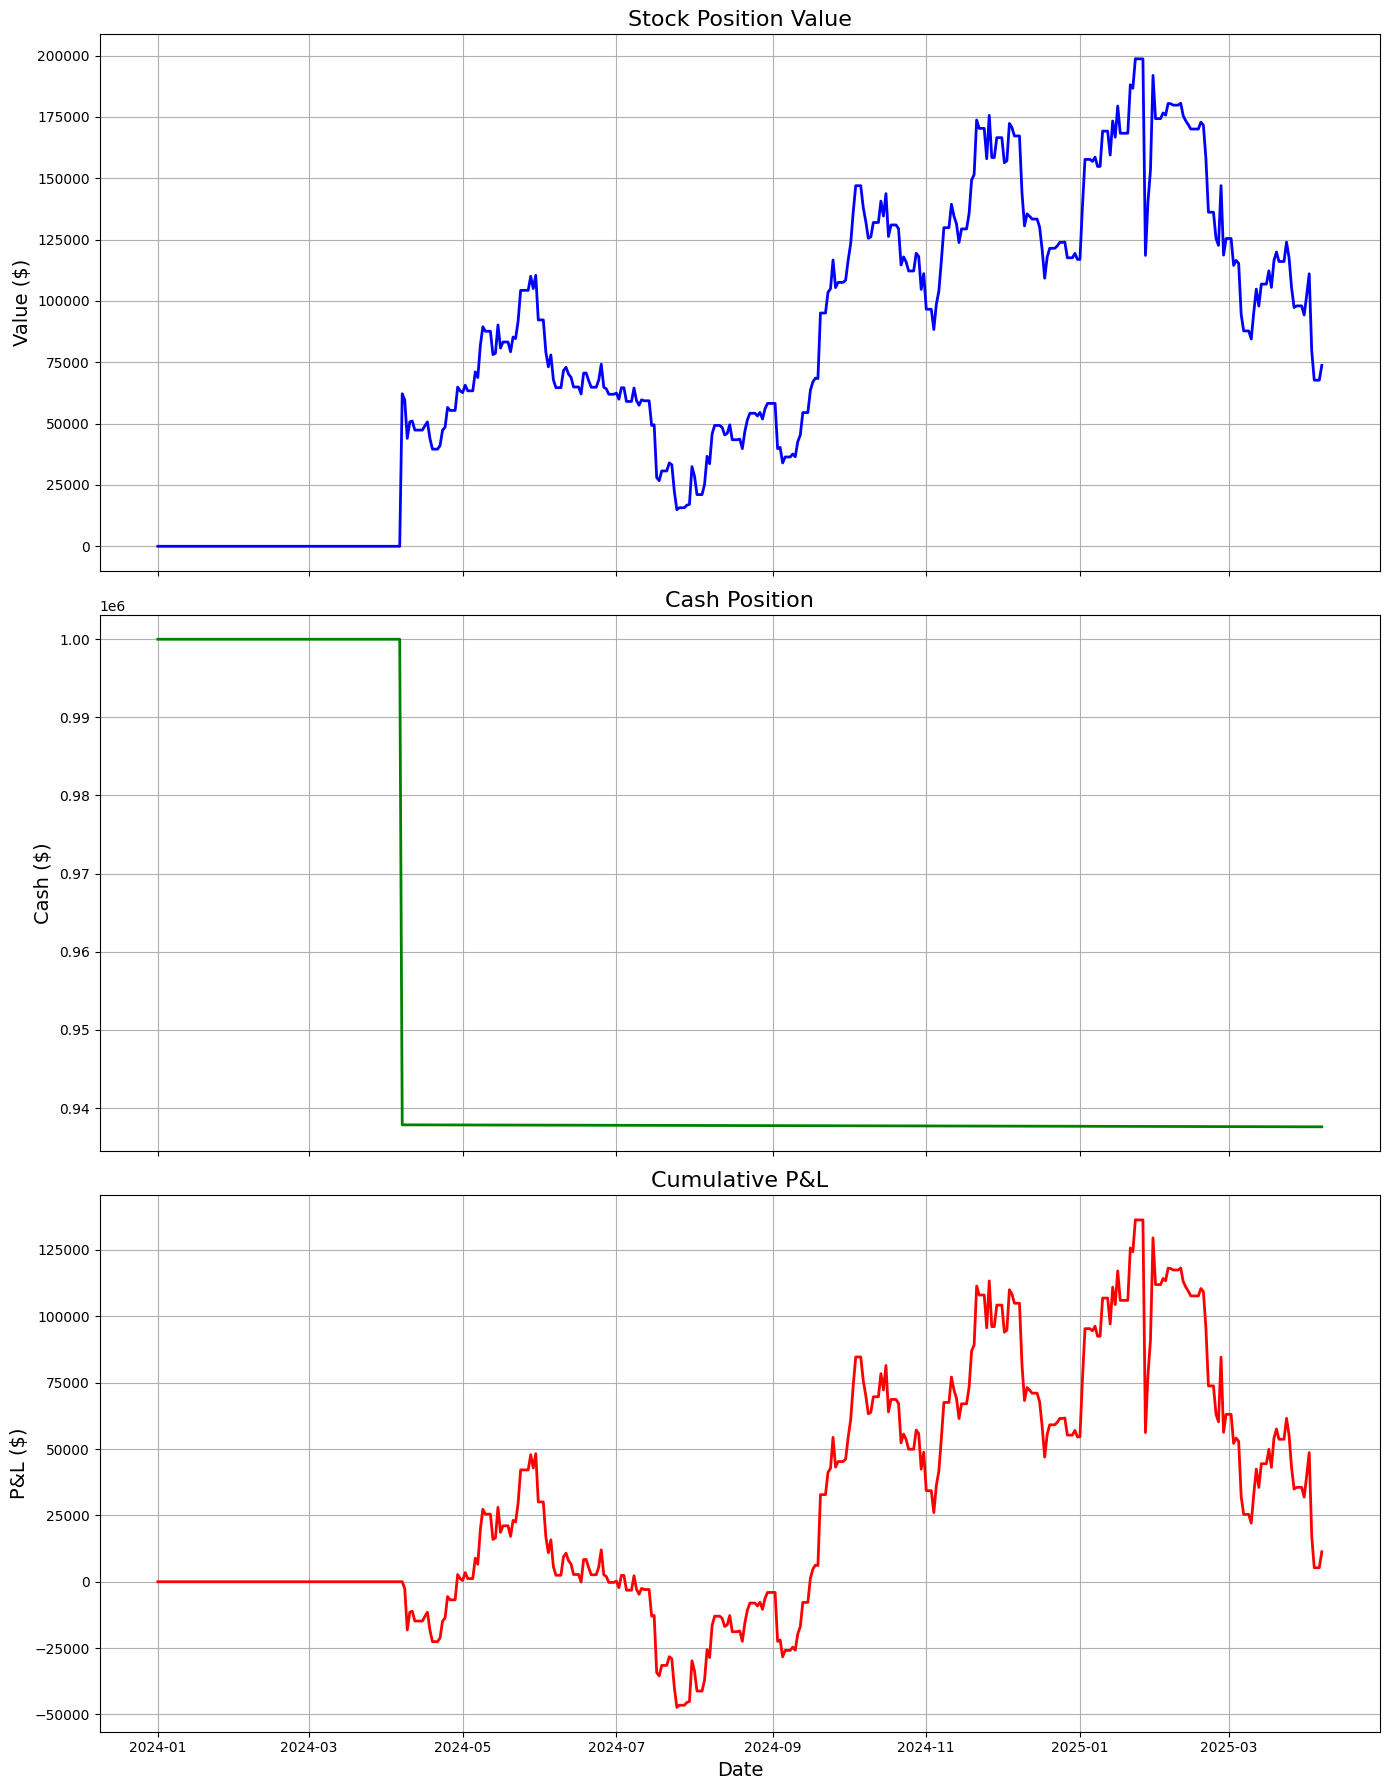

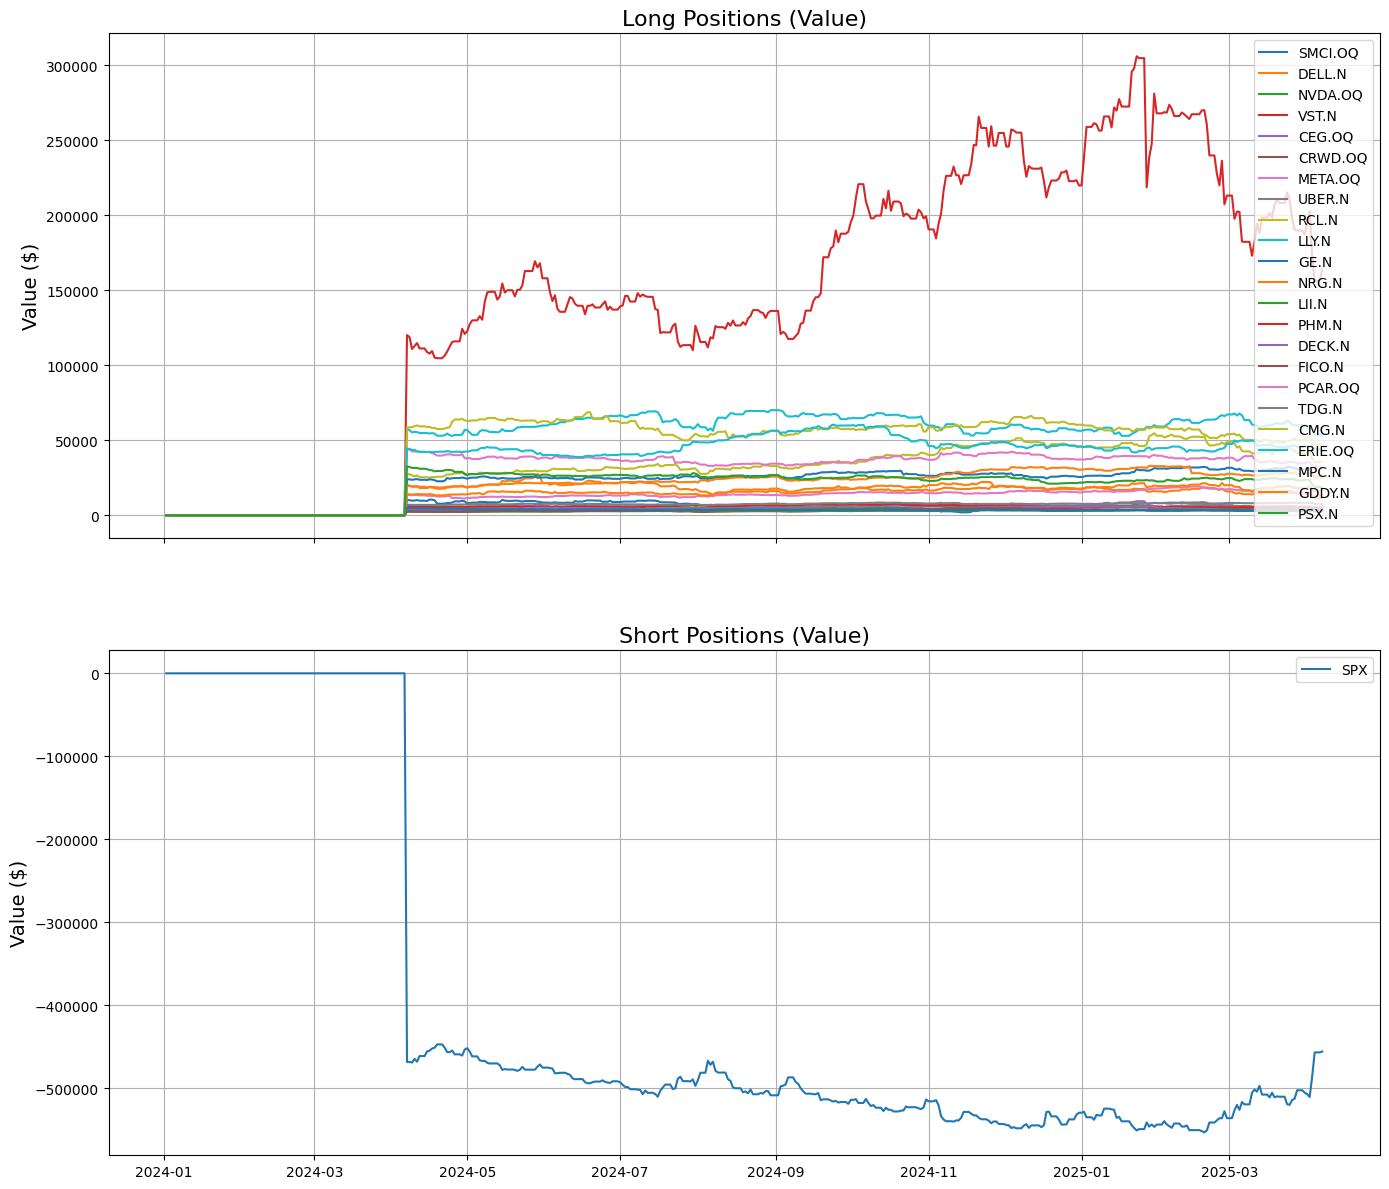

In [18]:
backtest, price_df = run_example_backtest()